In [4]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [5]:
%matplotlib inline

from session.sessions import selected_009266
from imports import *
from loading import load_session_data
from target import get_spike_counts, build_silence_matrix
from scipy import stats

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [30]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [31]:
AL_units = ['3-15', '3-4', '3-18', '3-18', '4-2', '3-9']
selected_idxs = [4, 5, 6, 7, 8, 9]
selected_sessions = [selected_009266[i] for i in selected_idxs]

In [34]:
# numer of timepoints is AL / non-AL state during silence, for every session
AL_state_sil_stats = np.zeros([len(selected_sessions), 2])
means_all = []  # collections of mean FRs for every session

for i, session in enumerate(selected_sessions):
    session_data = load_session_data(session)
    
    # state defined by AL unit 
    unit = AL_units[i]
    i_rate = session_data['single_units'][unit]
    thresh = i_rate.mean()
    std = i_rate.std() if 1 else 0  # 0 for now
    idxs_high = np.where(i_rate >  thresh + 0.5*std)
    idxs_low  = np.where(i_rate <= thresh - 0.5*std)

    # silence matrix
    s_matrix = build_silence_matrix(session_data['tl'])
    #idxs_silence  = np.concatenate([np.arange(r[0], r[1]) for r in s_matrix])
    idxs_silence  = np.where(session_data['tl'][:, 6] == 1)[0]
    idxs_sil_high = np.intersect1d(idxs_silence, idxs_high)
    idxs_sil_low  = np.intersect1d(idxs_silence, idxs_low)
    AL_state_sil_stats[i] = (len(idxs_sil_high), len(idxs_sil_low))
        
    # A1 units only
    selected = [unit for unit in session_data['unit_names'] if int(unit[0]) < 3]
    means = np.zeros([len(selected), 2])
    for i, unit_name in enumerate(selected):
        i_rate = session_data['single_units'][unit_name]
        means[i] = (i_rate[idxs_sil_high].mean(), i_rate[idxs_sil_low].mean())
        #means[i] = (i_rate[idxs_high].mean(), i_rate[idxs_low].mean())
        
    means_all.append(means)
    print("Session %s done" % session)

Session 009266_hippoSIT_2023-04-20_08-57-39 done
Session 009266_hippoSIT_2023-04-20_15-24-14 done
Session 009266_hippoSIT_2023-04-21_08-43-00 done
Session 009266_hippoSIT_2023-04-21_13-12-31 done
Session 009266_hippoSIT_2023-04-24_10-08-11 done
Session 009266_hippoSIT_2023-04-24_16-56-55 done


Text(0.5, 1.0, 'Active listening in silence')

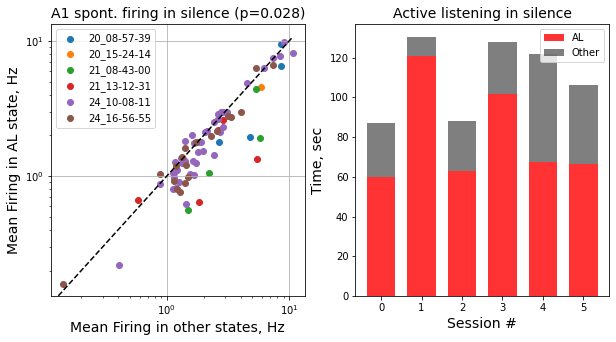

In [35]:
v_max, v_min = 0, 0
for m_mat in means_all:
    if m_mat.min() < v_min:
        v_min = m_mat.min()
    if m_mat.max() > v_max:
        v_max = m_mat.max()

# diff b/w means in both states
means_high = np.concatenate([m[:, 0] for m in means_all])
means_low  = np.concatenate([m[:, 1] for m in means_all])
stats_res  = stats.ttest_ind(means_high, means_low)
stats_res  = stats.ks_2samp(means_high, means_low)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]  # firing rates
for i, means in enumerate(means_all):
    ax.scatter(means[:, 1], means[:, 0], label=selected_sessions[i][-11:])
ax.plot([v_min, v_max], [v_min, v_max], ls='--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
ax.set_ylabel('Mean Firing in AL state, Hz', fontsize=14)
ax.set_xlabel('Mean Firing in other states, Hz', fontsize=14)
ax.set_title('A1 spont. firing in silence (p=%.3f)' % stats_res[1], fontsize=14)
ax.legend(loc='upper left')

width = 0.7
s_rate = 100
ax = axes[1]
x_vals = np.arange(len(AL_state_sil_stats))
ax.bar(x_vals, AL_state_sil_stats[:, 0]/s_rate, width, label='AL', color='red', alpha=0.8)
ax.bar(x_vals, AL_state_sil_stats[:, 1]/s_rate, width, \
       bottom=AL_state_sil_stats[:, 0]/s_rate, label='Other', color='black', alpha=0.5)
ax.legend(loc='upper right')
ax.set_xlabel('Session #', fontsize=14)
ax.set_ylabel('Time, sec', fontsize=14)
ax.set_title('Active listening in silence', fontsize=14)